In [1]:
import numpy as np
import pandas as  pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import *
import matplotlib.pyplot as plt
import math
plt.rcParams["figure.figsize"] = (20,10)


## Import Data


In [2]:
X = pd.read_csv("../Baseline/data_UE1_600/X_600_TTI.csv", index_col=0)
y = pd.read_csv("../Baseline/data_UE1_600/y_600_TTI.csv", index_col=0)



In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.4, shuffle=False)

In [4]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(354, 1280)
(354, 3840)
(236, 1280)
(236, 3840)


In [5]:
X_train = (X_train.to_numpy())
X_test = (X_test.to_numpy())
y_train = (y_train.to_numpy())
y_test = (y_test.to_numpy())

In [6]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_esc = scaler.transform(X_train)
X_test_esc = scaler.transform(X_test)


scaler = preprocessing.StandardScaler().fit(y_train)
y_train_esc = scaler.transform(y_train)
y_test_esc = scaler.transform(y_test)


## Create a sampling layer


In [7]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Build the encoder


In [8]:
latent_dim = 50
input_dim = X_train.shape[1]

encoder_inputs = keras.Input(shape=( input_dim, ))
x = layers.Dense(640, activation="relu")(encoder_inputs)
x = layers.Dense(320, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(16, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1280)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 640)          819840      ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 320)          205120      ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 32)           10272       ['dense_1[0][0]']                
                                                                                            

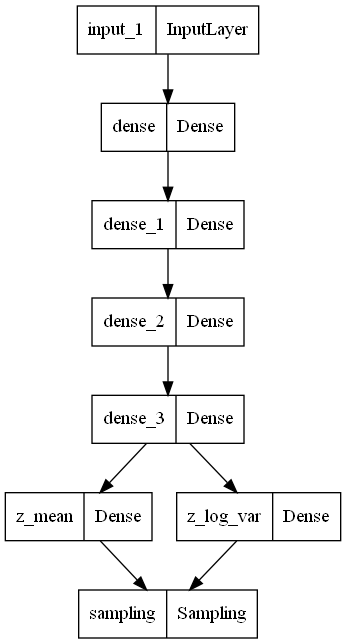

In [9]:
from keras.utils.vis_utils import plot_model
keras.utils.plot_model(encoder, to_file='encoder.png')

## Build the decoder


In [10]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(16,  activation="relu")(latent_inputs)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(320, activation="relu")(x)
x = layers.Dense(618, activation="relu")(x)

decoder_outputs = layers.Dense(input_dim * 3, activation="linear")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50)]              0         
                                                                 
 dense_4 (Dense)             (None, 16)                816       
                                                                 
 dense_5 (Dense)             (None, 64)                1088      
                                                                 
 dense_6 (Dense)             (None, 320)               20800     
                                                                 
 dense_7 (Dense)             (None, 618)               198378    
                                                                 
 dense_8 (Dense)             (None, 3840)              2376960   
                                                                 
Total params: 2,598,042
Trainable params: 2,598,042
Non-tra

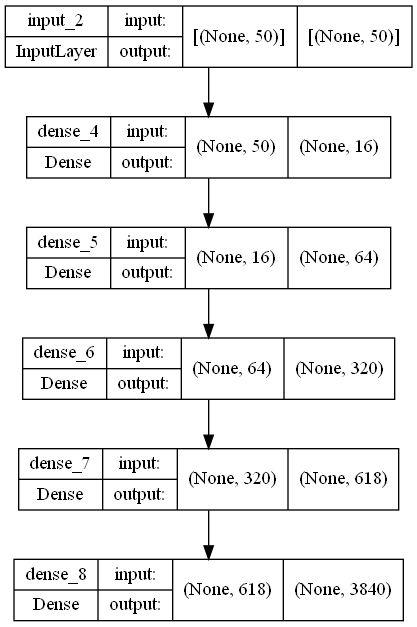

In [11]:
plot_model(decoder,  show_shapes=True, show_layer_names=True)

## Define the VAE as a Model with a custom train_step


In [12]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")  #MEAN? 
        self.reconstruction_loss_tracker = keras.metrics.Mean(    #MEAN? 
            name="MSE"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")   #MEAN? 
        
        self.total_loss_tracker_val = keras.metrics.Mean(name="total_loss_val")  #MEAN? 
        self.reconstruction_loss_tracker_val = keras.metrics.Mean(    #MEAN? 
            name="MSE_val"
        )
        self.kl_loss_tracker_val = keras.metrics.Mean(name="kl_loss_val")   #MEAN? 

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            
            self.total_loss_tracker_val,
            self.reconstruction_loss_tracker_val,
            self.kl_loss_tracker_val
        ]

    def train_step(self, data):
        x, y_true = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            reconstruction_loss = keras.losses.mean_squared_error(y_true, reconstruction)
            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            #kl_loss = tf.reduce_mean(kl_loss, axis=1)
            
            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "MSE": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        # Unpack the data
        x, y_true = data
        # Compute predictions
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        
        ## Losses
        reconstruction_loss = keras.losses.mean_squared_error(y_true, reconstruction)
        
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        
        total_loss = reconstruction_loss + kl_loss

        # Updates the metrics tracking the loss
        self.total_loss_tracker_val.update_state(total_loss)
        
        self.reconstruction_loss_tracker_val.update_state(reconstruction_loss)
        
        self.kl_loss_tracker_val.update_state(kl_loss)
        
        return {
            "loss_val": self.total_loss_tracker_val.result(),
            "MSE_val": self.reconstruction_loss_tracker_val.result(),
            "kl_loss_val": self.kl_loss_tracker_val.result(),
        }



    def call(self, inputs):

        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
                


        return reconstruction
    


## Train the VAE

In [13]:
vae = VAE(encoder, decoder)

In [14]:
vae.compile(optimizer=keras.optimizers.Adam())

In [15]:
es = keras.callbacks.EarlyStopping(
    monitor="MAE",
    patience=4,
)

In [16]:
history = vae.fit(X_train_esc, y_train_esc, validation_data=(X_test_esc, y_test_esc), epochs=10, batch_size=1, shuffle=False)#, callbacks=es)

Epoch 1/10
354/354 [==============================] - 8s 21ms/step - loss: 1.1407 - MSE: 0.8711 - kl_loss: 0.0606 - val_loss_val: 1.2489 - val_MSE_val: 1.2488 - val_kl_loss_val: 3.0458e-05
Epoch 2/10
354/354 [==============================] - 7s 21ms/step - loss: 0.9083 - MSE: 0.8612 - kl_loss: 5.5421e-05 - val_loss_val: 1.3145 - val_MSE_val: 1.3143 - val_kl_loss_val: 1.6320e-04
Epoch 3/10
354/354 [==============================] - 7s 21ms/step - loss: 0.9143 - MSE: 0.8567 - kl_loss: 7.5297e-05 - val_loss_val: 1.5234 - val_MSE_val: 1.5232 - val_kl_loss_val: 1.5241e-04
Epoch 4/10
354/354 [==============================] - 8s 21ms/step - loss: 0.8983 - MSE: 0.8555 - kl_loss: 7.9959e-05 - val_loss_val: 1.3306 - val_MSE_val: 1.3306 - val_kl_loss_val: 2.4647e-05
Epoch 5/10
354/354 [==============================] - 7s 21ms/step - loss: 0.9186 - MSE: 0.8862 - kl_loss: 5.3663e-05 - val_loss_val: 1.2932 - val_MSE_val: 1.2931 - val_kl_loss_val: 1.0094e-04
Epoch 6/10
354/354 [===================

In [17]:
print(history.history.keys())

dict_keys(['loss', 'MSE', 'kl_loss', 'val_loss_val', 'val_MSE_val', 'val_kl_loss_val'])


In [18]:
samp_num = 1

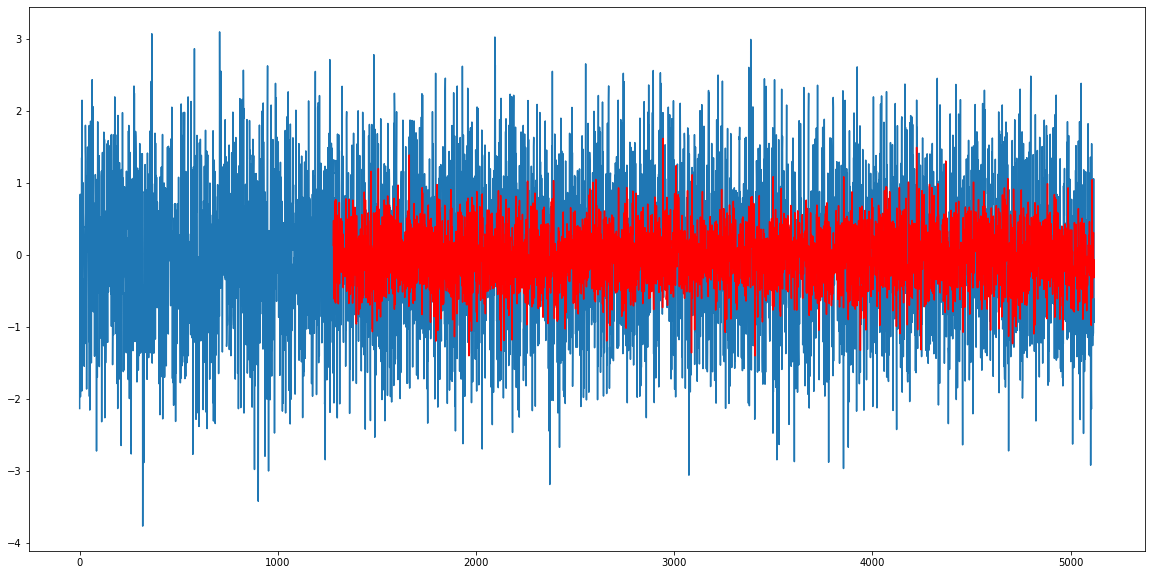

In [19]:
sample_1 = np.r_[ y_test_esc[samp_num,], X_test_esc[samp_num,]]
idx = np.arange(len(sample_1))
plt.plot(sample_1)
plt.plot(idx[-len(vae.predict(X_test_esc)[samp_num,]):], vae.predict(X_test_esc)[samp_num,], color='red')


In [20]:
print(history.history.keys())

dict_keys(['loss', 'MSE', 'kl_loss', 'val_loss_val', 'val_MSE_val', 'val_kl_loss_val'])


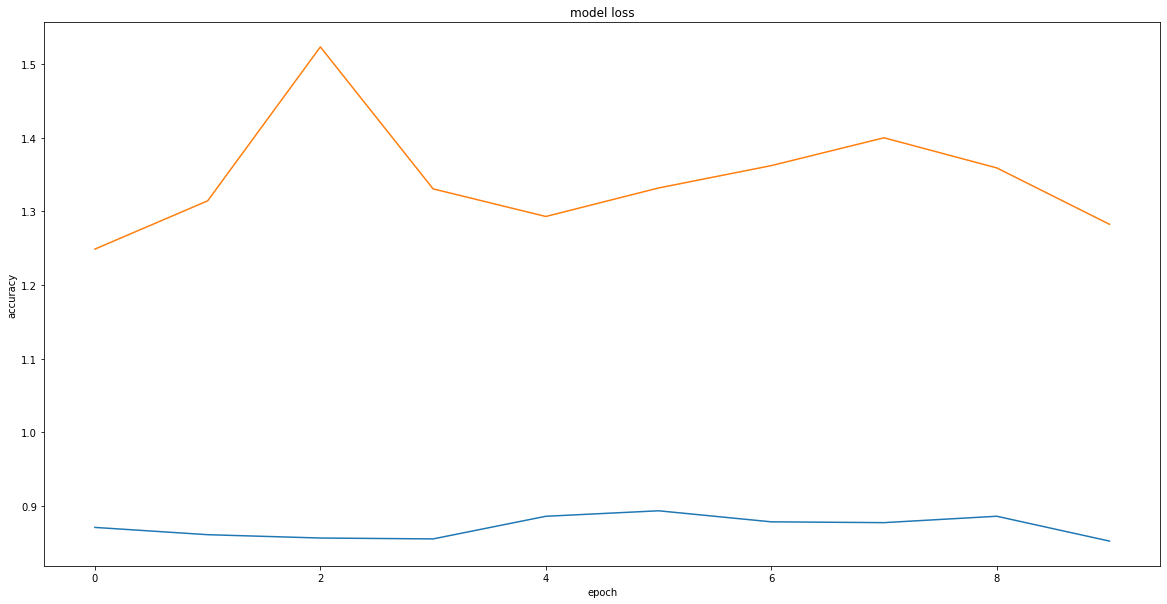

In [21]:
# summarize history for accuracy
plt.plot(history.history['MSE'])
#plt.plot(history.history['val_total_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(history.history['val_MSE_val'])

#plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [32]:
def nrmse(y_pred, y_test):
    
    num = tf.math.reduce_sum(tf.square(y_pred - y_test))
    num = num / y_test.shape[1]
    
    den = tf.math.reduce_sum(tf.square(y_test))/y_test.shape[1]
    
    return (num/den).numpy()

def mse(y_pred, y_test):
    
    num = tf.math.reduce_sum(tf.square(y_pred - y_test))
    num = num / y_test.shape[1]
    
    return num.numpy()

def mae(y_pred, y_test):
    
    num = tf.math.reduce_sum(tf.abs(y_pred - y_test))
    num = num / y_test.shape[1]
    
    return num.numpy()

print('NRMSE', nrmse(vae.predict(X_test), y_test))
print('MAE', mae(vae.predict(X_test), y_test))
print('RMSE', math.sqrt(mse(vae.predict(X_test), y_test)))
print('MSE', mse(vae.predict(X_test), y_test))


NRMSE 1.0341484360228477
MAE 12.12310819445792
RMSE 1.6218410851939626
MSE 2.6304156310365494
